<a href="https://colab.research.google.com/github/realqiyan/colab/blob/master/lightning_helloworld_temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 定义算法模型

In [7]:
import torch
from torch import nn

class HelloWorldModule(nn.Module):
    '''算法模型'''
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.Tensor([0.]))
        self.b = nn.Parameter(torch.Tensor([0.]))

    def forward(self, x):
        return self.w * x + self.b


# 构造实验数据

模型：$y = w*x+b$

在线温度转换：https://qq.ip138.com/converter6.htm

In [21]:
import pandas as pd

# -5摄氏度 = 23华氏度
# -1摄氏度 = 30.2华氏度
# 7摄氏度 = 44.6华氏度
# 13摄氏度 = 55.4华氏度
# 18摄氏度 = 64.4华氏度
# 20摄氏度 = 68华氏度
# 26摄氏度 = 78.8华氏度
df = pd.DataFrame({'X':[-5.0,-1,7.0,13,18.0,20.0,26.0],'y':[23.0,30.2,44.6,55.4,64.4,68.0,78.8]})
df

,X,y
0,-5.0,23.0
1,-1.0,30.2
2,7.0,44.6
3,13.0,55.4
4,18.0,64.4
5,20.0,68.0
6,26.0,78.8


# 训练相关方法

In [9]:
!pip install lightning -q

In [62]:
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl

class TrainingModule(pl.LightningModule):
    '''Lightning的训练框架'''
    def __init__(self, net):
        super().__init__()
        self.net = net

    def __loss__(self, batch, batch_idx):
        '''损失函数:(预测值-实际值)的平方'''
        X, y = batch
        return (self.net(X)-y)**2

    def training_step(self, batch, batch_idx):
        loss = self.__loss__(batch, batch_idx)
        self.log("training_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.__loss__(batch, batch_idx)
        self.log("validation_loss", loss)

    def configure_optimizers(self):
        #optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        optimizer = torch.optim.SGD([
                {'params': [self.net.w], 'lr': 0.01},
                {'params': [self.net.b], 'lr': 0.01}
            ])
        return optimizer


class CommonDataset(Dataset):
    '''训练数据集'''
    def __init__(self, data, y_names):
        self.data = data
        all_column_names = data.columns.tolist()
        self.y_names = y_names
        self.X_names = [col for col in all_column_names if col not in y_names]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        X = self.data.loc[i, self.X_names]
        X = torch.Tensor(X.to_numpy())
        y = self.data.loc[i, self.y_names]
        y = torch.Tensor(y.to_numpy())
        return X,y

# 训练模型

In [69]:
import torch.utils.data as data
# 90%用于训练 10%用于验证
train_set_size = int(len(df) * 0.9)
valid_set_size = len(df) - train_set_size

train_set, valid_set = data.random_split(
    CommonDataset(df,["y"]),
    [train_set_size, valid_set_size],
    generator=torch.Generator().manual_seed(10)
)

# 超简化模型，batch_size只能为1
train_loader = DataLoader(train_set, batch_size=1)
val_loader = DataLoader(valid_set, batch_size=1)

# model
helloworld = HelloWorldModule()
model = TrainingModule(helloworld)

# train model
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=val_loader)

for name, param in helloworld.named_parameters():
    print(name, param.data)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name | Type             | Params
------------------------------------------
0 | net  | HelloWorldModule | 2     
------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name | Type             | Params
------------------------------------------
0 | net  | HelloWorldModule | 2     
------------------------------------------
2    

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


w tensor([1.7951])
b tensor([31.9993])


# 验证模型

103.80271


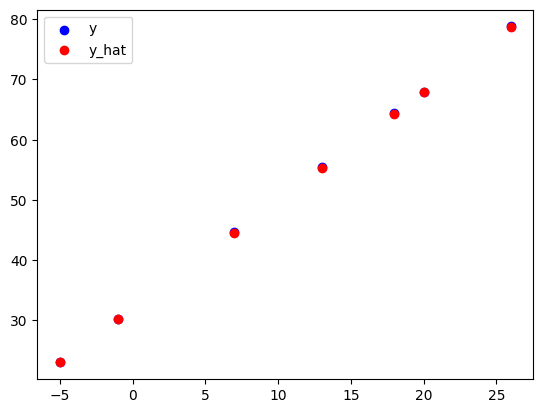

In [71]:
import matplotlib.pyplot as plt


val = 40.
print(helloworld(torch.Tensor([val])).detach().numpy()[0])

y_hat = []
X = df['X']
for i in X:
    # 添加一些随即变量
    y_hat.append(helloworld(torch.Tensor([i])).detach().numpy()[0])

vdf = pd.concat([df,pd.DataFrame({'y_hat': y_hat})],axis=1)
plt.scatter(vdf['X'], vdf['y'], color='blue', label='y')
plt.scatter(vdf['X'], vdf['y_hat'], color='red', label='y_hat')
plt.legend()# 添加图例
plt.show()

# 观察

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs/ --host=0.0.0.0

In [ ]:
import os
for dirname, _, filenames in os.walk('./lightning_logs/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./lightning_logs/version_0/events.out.tfevents.1695793527.044f8e759843.155.0
./lightning_logs/version_0/hparams.yaml
./lightning_logs/version_0/checkpoints/epoch=99-step=1800.ckpt
./lightning_logs/version_2/hparams.yaml
./lightning_logs/version_2/events.out.tfevents.1695793852.044f8e759843.155.2
./lightning_logs/version_2/checkpoints/epoch=29-step=540.ckpt
./lightning_logs/version_1/events.out.tfevents.1695793678.044f8e759843.155.1
./lightning_logs/version_1/hparams.yaml
./lightning_logs/version_1/checkpoints/epoch=19-step=360.ckpt


In [ ]:
import torch

with open('./lightning_logs/version_2/checkpoints/epoch=29-step=540.ckpt','rb') as f:
    data = torch.load(f,map_location='cpu')
    print(data)

{'epoch': 29, 'global_step': 540, 'pytorch-lightning_version': '2.0.9', 'state_dict': OrderedDict([('net.w', tensor([5.5123])), ('net.b', tensor([5.3993]))]), 'loops': {'fit_loop': {'state_dict': {}, 'epoch_loop.state_dict': {'_batches_that_stepped': 540}, 'epoch_loop.batch_progress': {'total': {'ready': 540, 'completed': 540, 'started': 540, 'processed': 540}, 'current': {'ready': 18, 'completed': 18, 'started': 18, 'processed': 18}, 'is_last_batch': True}, 'epoch_loop.scheduler_progress': {'total': {'ready': 0, 'completed': 0}, 'current': {'ready': 0, 'completed': 0}}, 'epoch_loop.automatic_optimization.state_dict': {}, 'epoch_loop.automatic_optimization.optim_progress': {'optimizer': {'step': {'total': {'ready': 540, 'completed': 540}, 'current': {'ready': 18, 'completed': 18}}, 'zero_grad': {'total': {'ready': 540, 'completed': 540, 'started': 540}, 'current': {'ready': 18, 'completed': 18, 'started': 18}}}}, 'epoch_loop.manual_optimization.state_dict': {}, 'epoch_loop.manual_optim

In [ ]:
checkpoint = "./lightning_logs/version_2/checkpoints/epoch=29-step=540.ckpt"
training_module = TrainingModule.load_from_checkpoint(checkpoint, net=HelloWorldModule())

model_load = training_module.net
model_load.eval()
for name, param in model_load.named_parameters():
    print(name, param.data)

2*math.e,math.e

w tensor([5.5123])
b tensor([5.3993])


(5.43656365691809, 2.718281828459045)